# Bootstrap Tutorial

This notebook contains a tutorial on how to use the bootstrap functionality provided by estimagic. We start with the simplest possible example of calculating standard errors and confidence intervals for an OLS estimator without as well as with clustering. Then we progress to more advanced examples.

In the example here, we will work with the "exercise" example dataset taken from the seaborn library.

The working example will be a linear regression to investigate the effects of exercise time on pulse.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import estimagic as em

## Prepare the dataset

In [2]:
df = sns.load_dataset("exercise", index_col=0)
replacements = {"1 min": 1, "15 min": 15, "30 min": 30}
df = df.replace({"time": replacements})
df["constant"] = 1

df.head()

,id,diet,pulse,time,kind,constant
0,1,low fat,85,1,rest,1
1,1,low fat,85,15,rest,1
2,1,low fat,88,30,rest,1
3,2,low fat,90,1,rest,1
4,2,low fat,92,15,rest,1


## Doing a very simple bootstrap

The first thing we need is a function that calculates the bootstrap outcome, given an empirical or re-sampled dataset. The bootstrap outcome is the quantity for which you want to calculate standard errors and confidence intervals. In most applications those are just parameter estimates.

In our case, we want to regress "pulse" on "time" and a constant. Our outcome function looks as follows:

In [3]:
def ols_fit(data):
    y = data["pulse"]
    x = data[["constant", "time"]]
    params = sm.OLS(y, x).fit().params

    return params

In general, the user-specified outcome function may return any pytree (e.g. numpy.ndarray, pandas.DataFrame, dict etc.). In the example here, it returns a pandas.Series.

Now we are ready to calculate confidence intervals and standard errors.

In [4]:
results_without_cluster = em.bootstrap(data=df, outcome=ols_fit)
results_without_cluster.ci()

(constant    90.858983
 time         0.151361
 dtype: float64,
 constant    96.880057
 time         0.654426
 dtype: float64)

In [5]:
results_without_cluster.se()

constant    1.548116
time        0.126410
dtype: float64

The above function call represents the minimum that a user has to specify, making full use of the default options, such as drawing a 1_000 bootstrap draws, using the "percentile" bootstrap confidence interval, not making use of parallelization, etc.

If, for example, we wanted to take 10_000 draws, while parallelizing on two cores, and using a "bc" type confidence interval, we would simply call the following:

In [6]:
results_without_cluster2 = em.bootstrap(
    data=df, outcome=ols_fit, n_draws=10_000, n_cores=2
)

results_without_cluster2.ci(ci_method="bc")

(constant    91.309379
 time         0.192349
 dtype: float64,
 constant    96.286624
 time         0.607616
 dtype: float64)

## Doing a clustered bootstrap

In the cluster robust variant of the bootstrap, the original dataset is divided into clusters according to the values of some user-specified variable, and then clusters are drawn uniformly with replacement in order to create the different bootstrap samples. 

In order to use the cluster robust boostrap, we simply specify which variable to cluster by. In the example we are working with, it seems sensible to cluster on individuals, i.e. on the column "id" of our dataset.

In [7]:
results_with_cluster = em.bootstrap(data=df, outcome=ols_fit, cluster_by="id")

results_with_cluster.se()

constant    1.185239
time        0.101723
dtype: float64

We can see that the estimated standard errors are indeed of smaller magnitude when we use the cluster robust bootstrap. 

Finally, we can compare our bootstrap results to a regression on the full sample using statsmodels' OLS function.
We see that the cluster robust bootstrap yields standard error estimates very close to the ones of the cluster robust regression, while the regular bootstrap seems to overestimate the standard errors of both coefficients.

**Note**: We would not expect the asymptotic statsmodels standard errors to be exactly the same as the bootstrapped standard errors.


In [8]:
y = df["pulse"]
x = df[["constant", "time"]]


cluster_robust_ols = sm.OLS(y, x).fit(cov_type="cluster", cov_kwds={"groups": df["id"]})

print(cluster_robust_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  pulse   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     13.75
Date:                Sat, 14 Jan 2023   Prob (F-statistic):           0.000879
Time:                        17:54:58   Log-Likelihood:                -365.51
No. Observations:                  90   AIC:                             735.0
Df Residuals:                      88   BIC:                             740.0
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      93.7611      1.205     77.837      0.0

## Splitting up the process

In many situations, the above procedure is enough. However, sometimes it may be important to split the bootstrapping process up into smaller steps. Examples for such situations are:

1. You want to look at the bootstrap estimates
2. You want to do a bootstrap with a low number of draws first and add more draws later without duplicated calculations
3. You have more bootstrap outcomes than just the parameters

### 1. Accessing bootstrap outcomes

The bootstrap outcomes are stored in the results object you get back when calling the bootstrap function. 

In [9]:
result = em.bootstrap(data=df, outcome=ols_fit, seed=1234)
my_outcomes = result.outcomes

my_outcomes[:5]

[constant    93.732040
 time         0.580057
 dtype: float64,
 constant    92.909468
 time         0.309198
 dtype: float64,
 constant    94.257886
 time         0.428624
 dtype: float64,
 constant    93.872576
 time         0.410508
 dtype: float64,
 constant    92.076689
 time         0.542170
 dtype: float64]

To further compare the cluster bootstrap to the uniform bootstrap, let's plot the sampling distribution of the parameters on time. We can again see that the standard error is smaller when we cluster on the subject id. 

In [10]:
result_clustered = em.bootstrap(data=df, outcome=ols_fit, seed=1234, cluster_by="id")
my_outcomes_clustered = result_clustered.outcomes

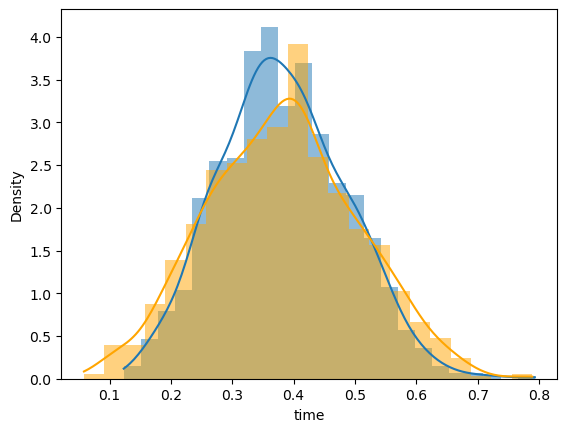

In [11]:
# clustered distribution in blue
sns.histplot(
    pd.DataFrame(my_outcomes_clustered)["time"], kde=True, stat="density", linewidth=0
)

# non-clustered distribution in orange
sns.histplot(
    pd.DataFrame(my_outcomes)["time"],
    kde=True,
    stat="density",
    linewidth=0,
    color="orange",
);

### Calculating standard errors and confidence intervals from existing bootstrap result

If you've already run ``bootstrap`` once, you can simply pass the existing result object to a new call of ``bootstrap``. Estimagic reuses the existing bootstrap outcomes and now only draws ``n_draws`` - ``n_existing`` outcomes instead of drawing entirely new ``n_draws``. Depending on the ``n_draws`` you specified (this is set to 1_000 by default), this may save considerable computation time. 

We can go on and compute confidence intervals and standard errors, just the same way as before, with several methods (e.g. "percentile" and "bc"), yet without duplicated evaluations of the bootstrap outcome function. 

In [12]:
my_results = em.bootstrap(
    data=df,
    outcome=ols_fit,
    existing_result=result,
)
my_results.ci(ci_method="t")

(constant    90.709236
 time         0.151193
 dtype: float64,
 constant    96.827145
 time         0.627507
 dtype: float64)

You can use this to calculate confidence intervals with several methods (e.g. "percentile" and "bc") without duplicated evaluations of the bootstrap outcome function.

## 2. Extending bootstrap results with more draws

It is often the case that, for speed reasons, you set the number of bootstrap draws quite low, so you can look at the results earlier and later decide that you need more draws. 

In the long run, we will offer a Dashboard integration for this. For now, you can do it manually.

As an example, we will take an initial sample of 500 draws. We then extend it with another 1500 draws. 

*Note*: It is very important to use a different random seed when you calculate the additional outcomes!!!

In [13]:
initial_result = em.bootstrap(data=df, outcome=ols_fit, seed=5471, n_draws=500)
initial_result.ci(ci_method="t")

(constant    90.768859
 time         0.137692
 dtype: float64,
 constant    96.601067
 time         0.607616
 dtype: float64)

In [14]:
combined_result = em.bootstrap(
    data=df, outcome=ols_fit, existing_result=initial_result, seed=2365, n_draws=2000
)
combined_result.ci(ci_method="t")

(constant    90.689112
 time         0.128597
 dtype: float64,
 constant    96.696522
 time         0.622954
 dtype: float64)

## 3. Using less draws than totally available bootstrap outcomes

You have a large sample of bootstrap outcomes but want to compute summary statistics only on a subset? No problem! Estimagic got you covered. You can simply pass any number of ``n_draws`` to your next call of ``bootstrap``, regardless of the size of the existing sample you want to use. We already covered the case where ``n_draws`` > ``n_existing`` above, in which case estimagic draws the remaining bootstrap outcomes for you.

If ``n_draws`` <= ``n_existing``, estimagic takes a random subset of the existing outcomes - and voilà! 

In [15]:
subset_result = em.bootstrap(
    data=df, outcome=ols_fit, existing_result=combined_result, seed=4632, n_draws=500
)
subset_result.ci(ci_method="t")

(constant    90.619182
 time         0.130242
 dtype: float64,
 constant    96.557777
 time         0.625645
 dtype: float64)

## Accessing the bootstrap samples

It is also possible to just access the bootstrap samples. You may do so, for example, if you want to calculate your bootstrap outcomes in parallel in a way that is not yet supported by estimagic (e.g. on a large cluster or super-computer).

In [16]:
from estimagic.inference import get_bootstrap_samples

rng = np.random.default_rng(1234)
my_samples = get_bootstrap_samples(data=df, rng=rng)
my_samples[0]

,id,diet,pulse,time,kind,constant
88,30,no fat,111,15,running,1
87,30,no fat,99,1,running,1
88,30,no fat,111,15,running,1
34,12,low fat,103,15,walking,1
15,6,no fat,83,1,rest,1
...,...,...,...,...,...,...
78,27,no fat,100,1,running,1
77,26,no fat,143,30,running,1
87,30,no fat,99,1,running,1
29,10,no fat,100,30,rest,1
